# ENote: Emotion in Music – Final Project Notebook
This notebook contains the full pipeline including visualizations, static CNN model, and dynamic sequence model.

## 1. Dataset loading and basic inspection  (Visualizations)


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf

DEAM_ROOT = os.path.abspath("DEAM")  # DEAM folder next to notebook

STATIC_ANN_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "song_level",
    "static_annotations_averaged_songs_1_2000.csv",
)

# NEW: dynamic averaged per second (valence + arousal)
DYNAMIC_VAL_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "valence.csv",
)

DYNAMIC_ARO_PATH = os.path.join(
    DEAM_ROOT,
    "DEAM_Annotations",
    "annotations",
    "annotations averaged per song",
    "dynamic (per second annotations)",
    "arousal.csv",
)

AUDIO_DIR = os.path.join(DEAM_ROOT, "DEAM_audio")
MODEL_PATH = "deam_cnn_valence_arousal.h5"

print("Static annotations:", os.path.exists(STATIC_ANN_PATH))
print("Dynamic val:", os.path.exists(DYNAMIC_VAL_PATH))
print("Dynamic aro:", os.path.exists(DYNAMIC_ARO_PATH))
print("Audio dir:", os.path.exists(AUDIO_DIR))


Static annotations: True
Dynamic val: True
Dynamic aro: True
Audio dir: True


In [3]:
dyn_val = pd.read_csv(DYNAMIC_VAL_PATH)
dyn_aro = pd.read_csv(DYNAMIC_ARO_PATH)

print("Valence shape:", dyn_val.shape)
print("Arousal shape:", dyn_aro.shape)
print("Valence columns (first 10):", dyn_val.columns[:10].tolist())
dyn_val.head()


Valence shape: (1802, 1224)
Arousal shape: (1802, 1225)
Valence columns (first 10): ['song_id', 'sample_15000ms', 'sample_15500ms', 'sample_16000ms', 'sample_16500ms', 'sample_17000ms', 'sample_17500ms', 'sample_18000ms', 'sample_18500ms', 'sample_19000ms']


,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_621500ms,sample_622000ms,sample_622500ms,sample_623000ms,sample_623500ms,sample_624000ms,sample_624500ms,sample_625000ms,sample_625500ms,sample_626000ms
0,2,-0.073341,-0.074661,-0.074077,-0.078154,-0.081588,-0.080873,-0.083611,-0.082145,-0.081632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,-0.189702,-0.187765,-0.183740,-0.188761,-0.193704,-0.190834,-0.189041,-0.197554,-0.202871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,0.154286,0.148063,0.146956,0.151180,0.135942,0.076832,0.084487,0.088513,0.090944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.149053,0.148260,0.147369,0.146956,0.147857,0.146927,0.145651,0.145795,0.146420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,0.342816,0.345193,0.332023,0.328887,0.327603,0.329011,0.327883,0.334822,0.328447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import numpy as np

# All column names
dyn_cols = dyn_val.columns.tolist()
print(dyn_cols[:10])

# First column is song_id, rest are samples at different ms
time_cols = dyn_cols[1:]

# Convert "sample_15000ms" -> 15.0 (seconds)
time_vals = []
for c in time_cols:
    num = c.replace("sample_", "").replace("ms", "")
    t_sec = int(num) / 1000.0
    time_vals.append(t_sec)

time_vals = np.array(time_vals)
print("First few time values (s):", time_vals[:10])
print("Length of time axis:", len(time_vals))


['song_id', 'sample_15000ms', 'sample_15500ms', 'sample_16000ms', 'sample_16500ms', 'sample_17000ms', 'sample_17500ms', 'sample_18000ms', 'sample_18500ms', 'sample_19000ms']
First few time values (s): [15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5]
Length of time axis: 1223


Plotting continuous emotion for song_id: 2
Raw val length: 1223
Raw aro length: 1224
Time length: 1223
After NaN removal: 60 points


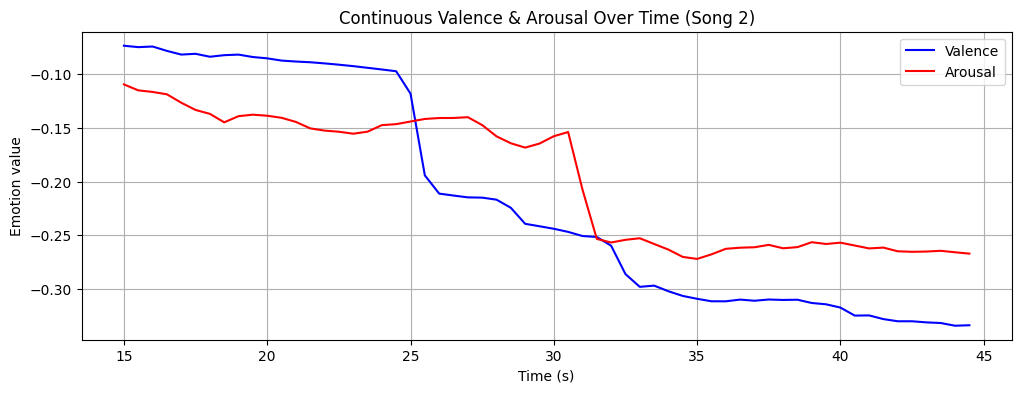

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a song row index
row_idx = 0  # change this to see other songs
song_id_example = dyn_val.iloc[row_idx, 0]
print("Plotting continuous emotion for song_id:", song_id_example)

# Extract raw series
val_raw = dyn_val.iloc[row_idx, 1:].values.astype(float)
aro_raw = dyn_aro.iloc[row_idx, 1:].values.astype(float)

print("Raw val length:", len(val_raw))
print("Raw aro length:", len(aro_raw))
print("Time length:", len(time_vals))

# Make all three the same length (min of the three)
L = min(len(val_raw), len(aro_raw), len(time_vals))
val_raw = val_raw[:L]
aro_raw = aro_raw[:L]
t_raw = time_vals[:L]

# Drop positions where val is NaN (common tail)
mask = ~np.isnan(val_raw)
val_series = val_raw[mask]
aro_series = aro_raw[mask]
time_series = t_raw[mask]

print("After NaN removal:", len(time_series), "points")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_series, val_series, label="Valence", color="blue")
plt.plot(time_series, aro_series, label="Arousal", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Emotion value")
plt.title(f"Continuous Valence & Arousal Over Time (Song {song_id_example})")
plt.legend()
plt.grid(True)
plt.show()


Most volatile valence song: 2013 var: 0.055846955024277015
Most volatile arousal song: 2014 var: 0.13297978116583478


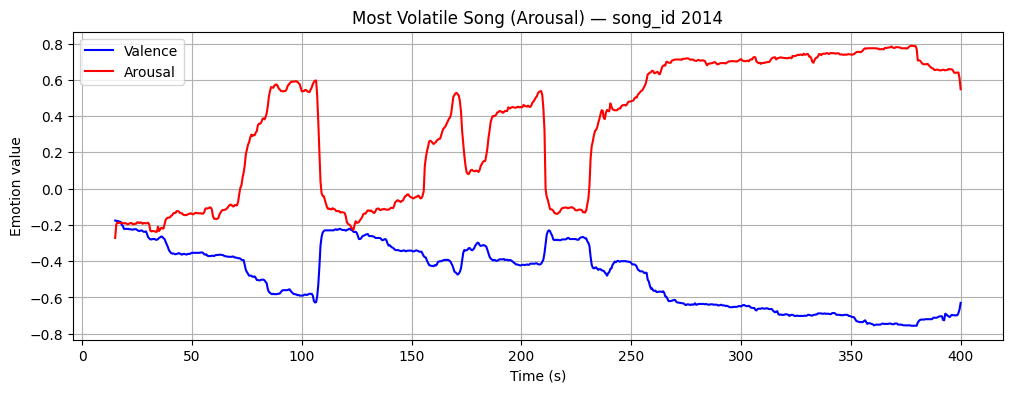

In [6]:
# Compute per-song variance for valence and arousal
song_ids = dyn_val["song_id"].values

var_val = []
var_aro = []

for i in range(len(dyn_val)):
    v = dyn_val.iloc[i, 1:].values.astype(float)
    a = dyn_aro.iloc[i, 1:].values.astype(float)

    v = v[~np.isnan(v)]
    a = a[~np.isnan(a)]

    var_val.append(np.var(v) if len(v) > 0 else 0)
    var_aro.append(np.var(a) if len(a) > 0 else 0)

var_val = np.array(var_val)
var_aro = np.array(var_aro)

# Find most volatile (highest variance)
val_volatile_idx = np.argmax(var_val)
aro_volatile_idx = np.argmax(var_aro)

print("Most volatile valence song:", song_ids[val_volatile_idx], "var:", var_val[val_volatile_idx])
print("Most volatile arousal song:", song_ids[aro_volatile_idx], "var:", var_aro[aro_volatile_idx])

# Helper to extract aligned series
def get_series(idx):
    v_raw = dyn_val.iloc[idx, 1:].values.astype(float)
    a_raw = dyn_aro.iloc[idx, 1:].values.astype(float)

    # Align lengths
    L = min(len(v_raw), len(a_raw), len(time_vals))
    v_raw = v_raw[:L]
    a_raw = a_raw[:L]
    t_raw = time_vals[:L]

    # remove NaNs
    mask = ~np.isnan(v_raw)
    return t_raw[mask], v_raw[mask], a_raw[mask]

# Plot most volatile song (Arousal)
t, v, a = get_series(aro_volatile_idx)

plt.figure(figsize=(12,4))
plt.plot(t, v, label="Valence", color="blue")
plt.plot(t, a, label="Arousal", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Emotion value")
plt.title(f"Most Volatile Song (Arousal) — song_id {song_ids[aro_volatile_idx]}")
plt.legend()
plt.grid()
plt.show()


In [7]:
import glob, os

print("AUDIO_DIR:", AUDIO_DIR)

audio_files_nonrec = glob.glob(os.path.join(AUDIO_DIR, "*.mp3"))
audio_files_rec = glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True)

print("num_audio non-recursive:", len(audio_files_nonrec))
print("num_audio recursive:", len(audio_files_rec))
print("First few recursive files:", [os.path.basename(f) for f in sorted(audio_files_rec)[:10]])


AUDIO_DIR: /Users/sakethkilaru/enote_deam_cnn/DEAM/DEAM_audio
num_audio non-recursive: 0
num_audio recursive: 1802
First few recursive files: ['10.mp3', '1000.mp3', '1001.mp3', '1002.mp3', '1003.mp3', '1004.mp3', '1005.mp3', '1006.mp3', '1007.mp3', '1008.mp3']


Total audio files (recursive): 1802
Most volatile arousal (within audio range):
  row index: 1757
  song_id: 2014
  variance: 0.13297978116583478
Using audio file: 941.mp3


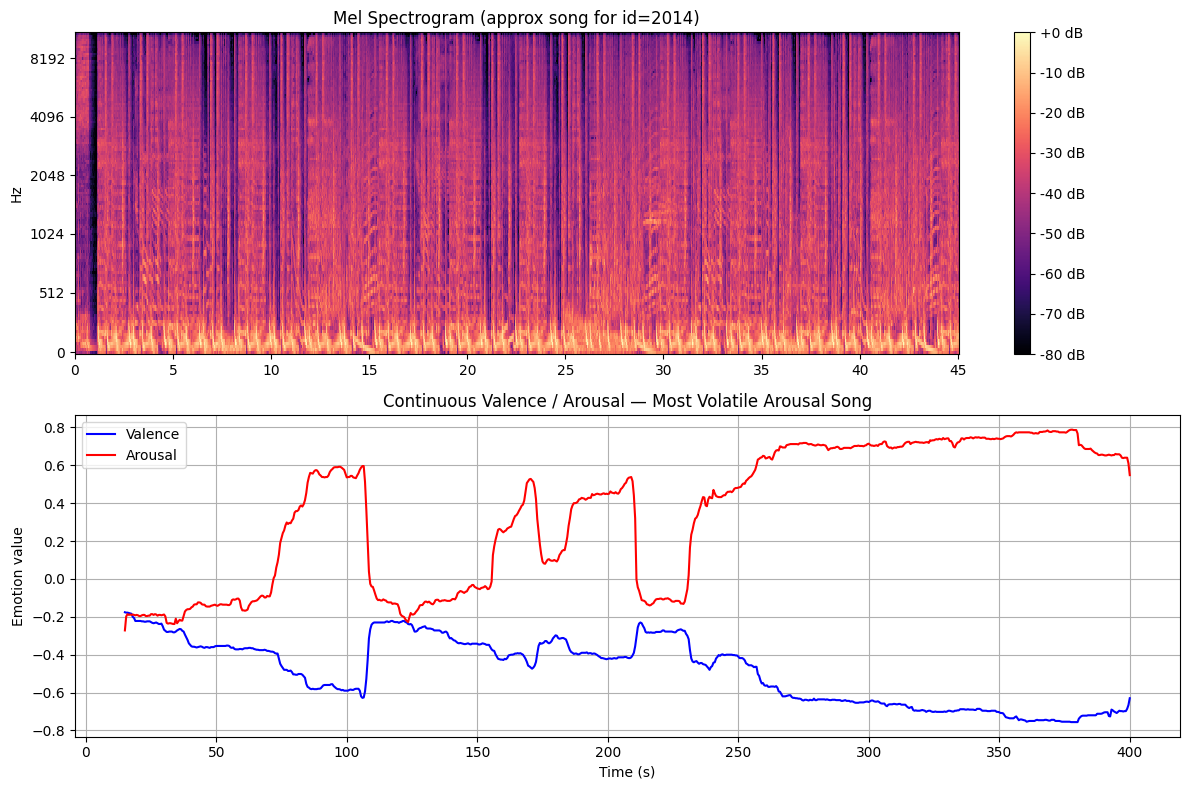

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
import os

# 1) Get audio files recursively (handles DEAM_audio/MEMD_audio)
audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True))
num_audio = len(audio_files)
print("Total audio files (recursive):", num_audio)

if num_audio == 0:
    raise ValueError("No audio files found. Check AUDIO_DIR and rerun the paths cell.")

# 2) Compute arousal variance only for rows that have matching audio index
song_ids = dyn_aro["song_id"].values

var_aro_restricted = []
for i in range(num_audio):
    a_row = dyn_aro.iloc[i, 1:].values.astype(float)
    a_row = a_row[~np.isnan(a_row)]
    var_aro_restricted.append(np.var(a_row) if len(a_row) > 0 else 0.0)

var_aro_restricted = np.array(var_aro_restricted)

aro_volatile_idx = int(np.argmax(var_aro_restricted))

print("Most volatile arousal (within audio range):")
print("  row index:", aro_volatile_idx)
print("  song_id:", song_ids[aro_volatile_idx])
print("  variance:", var_aro_restricted[aro_volatile_idx])

# 3) Helper to get aligned valence/arousal/time for that index
def get_series(idx):
    v_raw = dyn_val.iloc[idx, 1:].values.astype(float)
    a_raw = dyn_aro.iloc[idx, 1:].values.astype(float)

    L = min(len(v_raw), len(a_raw), len(time_vals))
    v_raw, a_raw, t_raw = v_raw[:L], a_raw[:L], time_vals[:L]

    mask = ~np.isnan(v_raw)
    return t_raw[mask], v_raw[mask], a_raw[mask]

t, v, a = get_series(aro_volatile_idx)

# 4) Pick matching audio file by index
target_file = audio_files[aro_volatile_idx]
print("Using audio file:", os.path.basename(target_file))

y, sr = librosa.load(target_file, sr=22050, mono=True)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# 5) Plot spectrogram + emotion curves
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Spectrogram
img = librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title(f"Mel Spectrogram (approx song for id={song_ids[aro_volatile_idx]})")
axs[0].set_xlabel("")
fig.colorbar(img, ax=axs[0], format="%+2.0f dB")

# Emotion curve
axs[1].plot(t, v, label="Valence", color="blue")
axs[1].plot(t, a, label="Arousal", color="red")
axs[1].set_title("Continuous Valence / Arousal — Most Volatile Arousal Song")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Emotion value")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


Least volatile arousal (within audio range):
  row index: 24
  song_id: 42
  variance: 1.3915617923187881e-05
Using audio file: 1021.mp3


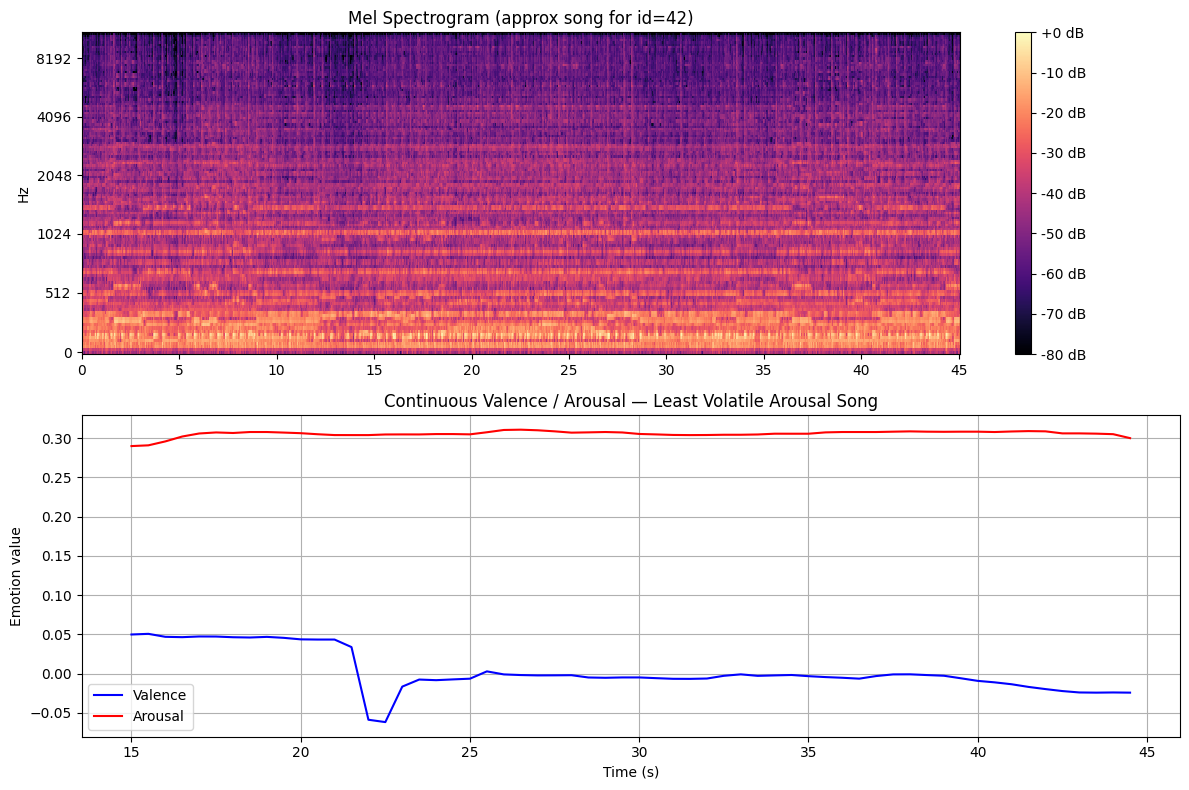

In [9]:
# Find least volatile arousal song within audio range
aro_least_idx = int(np.argmin(var_aro_restricted))

print("Least volatile arousal (within audio range):")
print("  row index:", aro_least_idx)
print("  song_id:", song_ids[aro_least_idx])
print("  variance:", var_aro_restricted[aro_least_idx])

# Emotion series
t_low, v_low, a_low = get_series(aro_least_idx)

# Matching audio file
target_file_low = audio_files[aro_least_idx]
print("Using audio file:", os.path.basename(target_file_low))

y_low, sr_low = librosa.load(target_file_low, sr=22050, mono=True)
S_low = librosa.feature.melspectrogram(y=y_low, sr=sr_low, n_mels=128)
S_low_db = librosa.power_to_db(S_low, ref=np.max)

# Plot spectrogram + curves for least volatile song
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Spectrogram
img2 = librosa.display.specshow(S_low_db, sr=sr_low, x_axis="time", y_axis="mel", ax=axs[0])
axs[0].set_title(f"Mel Spectrogram (approx song for id={song_ids[aro_least_idx]})")
axs[0].set_xlabel("")
fig.colorbar(img2, ax=axs[0], format="%+2.0f dB")

# Emotion curve
axs[1].plot(t_low, v_low, label="Valence", color="blue")
axs[1].plot(t_low, a_low, label="Arousal", color="red")
axs[1].set_title("Continuous Valence / Arousal — Least Volatile Arousal Song")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Emotion value")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


In [11]:
import glob
import numpy as np
import pandas as pd
import librosa

SR = 22050
N_MELS = 128
FRAMES = 128
MAX_SONGS = 800  # feel free to bump if it runs fine

STATIC_DF = pd.read_csv(STATIC_ANN_PATH)
ID_COL = "song_id"
VAL_COL = " valence_mean"
ARO_COL = " arousal_mean"

# same cleaning as before
STATIC_DF = STATIC_DF[[ID_COL, VAL_COL, ARO_COL]].dropna()
STATIC_DF = STATIC_DF.sort_values(ID_COL).reset_index(drop=True)

audio_files = sorted(glob.glob(os.path.join(AUDIO_DIR, "**", "*.mp3"), recursive=True))
print("Audio files:", len(audio_files), "Rows in static df:", len(STATIC_DF))

N = min(MAX_SONGS, len(audio_files), len(STATIC_DF))
print("Using N =", N)

def make_mel(path, sr=SR, n_mels=N_MELS, frames=FRAMES):
    y, sr = librosa.load(path, sr=sr, mono=True)
    max_samples = sr * 30
    if len(y) > max_samples:
        y = y[:max_samples]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db + 80.0) / 80.0
    if mel_db.shape[1] < frames:
        pad = frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0),(0,pad)), mode="constant")
    else:
        mel_db = mel_db[:, :frames]
    return mel_db[..., np.newaxis]

X_list = []
y_list = []

for i in range(N):
    row = STATIC_DF.iloc[i]
    path = audio_files[i]
    try:
        mel = make_mel(path)
    except Exception as e:
        print("Skip", path, "error:", e)
        continue
    X_list.append(mel)
    y_list.append([row[VAL_COL], row[ARO_COL]])

X = np.stack(X_list, axis=0)
y = np.array(y_list, dtype=np.float32)

print("Final shapes:", X.shape, y.shape)


Audio files: 1802 Rows in static df: 1744
Using N = 800
Final shapes: (800, 128, 128, 1) (800, 2)


## 2. Static Model (CNN)

In [12]:

from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assume X, y already prepared.

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def build_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

cnn_model = build_cnn(X_train.shape[1:])
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=8
)
cnn_model.save("static_cnn_model.keras")


Epoch 1/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 17.8848 - mae: 4.0111 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 2/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 16.9441 - mae: 3.8965 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 3/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 16.6462 - mae: 3.8751 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 4/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 16.5896 - mae: 3.8610 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 5/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 16.8129 - mae: 3.8722 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 6/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 16.2872 - mae: 3.8023 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 7/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 16.3844 - mae: 3.8319 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 8/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 16.5095 - mae: 3.8411 - val_loss: 17.4206 - val_mae: 3.9953
Epoch 9/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/st

In [13]:

test_loss, test_mae = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Static model test MSE:", float(test_loss))
print("Static model test MAE:", float(test_mae))


Static model test MSE: 16.209095001220703
Static model test MAE: 3.802187442779541


## 3. Dynamic Sequence Model (BiLSTM)

In [19]:

# Assume X_dyn, y_dyn are built

X_train_dyn, X_val_dyn, y_train_dyn, y_val_dyn = train_test_split(X_dyn, y_dyn, test_size=0.2, random_state=42)

def build_dynamic_model(seq_len, feat_dim):
    inp = tf.keras.layers.Input(shape=(seq_len, feat_dim))
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inp)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

dyn_model = build_dynamic_model(X_train_dyn.shape[1], X_train_dyn.shape[2])

history_dyn = dyn_model.fit(
    X_train_dyn, y_train_dyn,
    validation_data=(X_val_dyn, y_val_dyn),
    epochs=12,
    batch_size=4
)
dyn_model.save("dynamic_sequence_model.keras")


Epoch 1/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - loss: 0.1656 - mae: 0.3315 - val_loss: 0.1375 - val_mae: 0.2997
Epoch 2/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.1129 - mae: 0.2587 - val_loss: 0.0955 - val_mae: 0.2542
Epoch 3/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0671 - mae: 0.1937 - val_loss: 0.0828 - val_mae: 0.2435
Epoch 4/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0413 - mae: 0.1641 - val_loss: 0.0747 - val_mae: 0.2233
Epoch 5/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0315 - mae: 0.1427 - val_loss: 0.0712 - val_mae: 0.2243
Epoch 6/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0231 - mae: 0.1214 - val_loss: 0.0686 - val_mae: 0.2162
Epoch 7/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0158 - mae: 0.0983 - val_loss: 0.0712 - val_mae: 0.2231
Epoch 8/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0120 - mae: 0.0860 - val_loss: 0.0745 - val_mae: 0.2236
Epoch 9/12
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0103 - mae: 

In [20]:

val_loss, val_mae = dyn_model.evaluate(X_val_dyn, y_val_dyn, verbose=0)
print("Dynamic model val MSE:", float(val_loss))
print("Dynamic model val MAE:", float(val_mae))


Dynamic model val MSE: 0.07191003113985062
Dynamic model val MAE: 0.22049744427204132


## 4. Single Song Dynamic Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


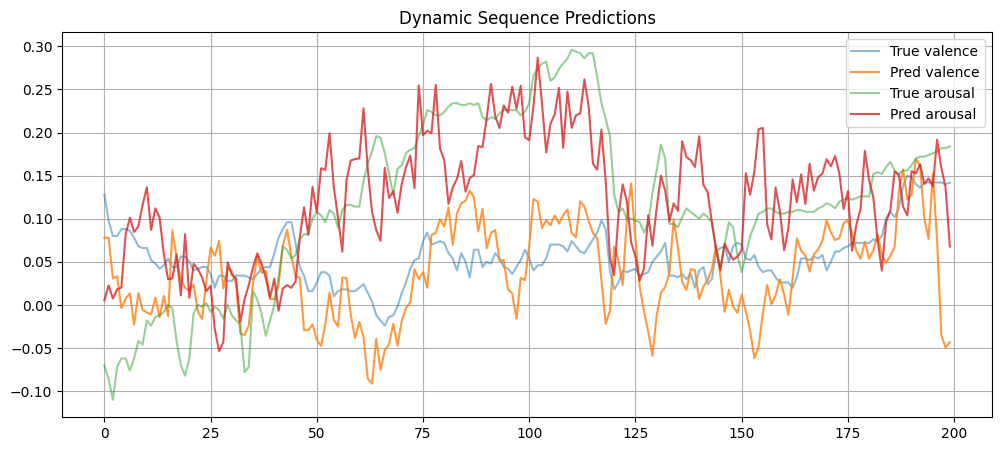

In [22]:

song_idx = 4

X_song = X_train_dyn[song_idx]
y_song = y_train_dyn[song_idx]

pred = dyn_model.predict(X_song[np.newaxis, :, :])[0]

import matplotlib.pyplot as plt
t = np.arange(len(pred))

plt.figure(figsize=(12,5))
plt.plot(t, y_song[:,0], alpha=0.5, label="True valence")
plt.plot(t, pred[:,0], alpha=0.8, label="Pred valence")
plt.plot(t, y_song[:,1], alpha=0.5, label="True arousal")
plt.plot(t, pred[:,1], alpha=0.8, label="Pred arousal")
plt.legend()
plt.grid()
plt.title("Dynamic Sequence Predictions")
plt.show()
